In [153]:
from transformers import (
    VisionEncoderDecoderModel, 
    ViTFeatureExtractor, 
    PreTrainedTokenizerFast,
    Trainer, 
    TrainingArguments,
    BertConfig, 
    ViTConfig, 
    VisionEncoderDecoderConfig,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    default_data_collator,
    AdamW,
    AutoTokenizer
)
import datasets
import torch
import numpy as np
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchvision import transforms
import os
import json

In [ ]:
with open('/opt/ml/final-project-level3-nlp-08/MSCOCO_train_val_Korean.json', 'r') as f:
    coco = json.load(f)

In [158]:
coco[0]

{'file_path': 'val2014/COCO_val2014_000000391895.jpg',
 'captions': ['A man with a red helmet on a small moped on a dirt road. ',
  'Man riding a motor bike on a dirt road on the countryside.',
  'A man riding on the back of a motorcycle.',
  'A dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud-wreathed mountains. ',
  'A man in a red shirt and a red hat is on a motorcycle on a hill side.'],
 'id': 391895,
 'caption_ko': ['빨간 헬멧을 쓴 남자가 작은 모터 달린 비포장 도로를 달려 있다.',
  '시골의 비포장 도로에서 오토바이를 타는 남자',
  '오토바이 뒤에 탄 남자',
  '오토바이 위에 젊은이가 탄 비포장 도로는 다리가 있는 초록빛 지역의 전경과 구름 낀 산의 배경이 있다.',
  '빨간 셔츠와 빨간 모자를 쓴 남자가 언덕 쪽 오토바이 위에 있다.']}

In [160]:
ls = []
ps = []

for i in range(len(coco)):
    ls.append(coco[i]['captions'][0])
    ps.append(coco[i]['file_path'])

coco_df = pd.DataFrame(data={
    'labels': ls,
    'img_paths': ps
})
coco_df

,labels,img_paths
0,A man with a red helmet on a small moped on a ...,val2014/COCO_val2014_000000391895.jpg
1,A woman wearing a net on her head cutting a ca...,val2014/COCO_val2014_000000522418.jpg
2,A child holding a flowered umbrella and pettin...,val2014/COCO_val2014_000000184613.jpg
3,A young boy standing in front of a computer ke...,val2014/COCO_val2014_000000318219.jpg
4,a boy wearing headphones using one computer in...,val2014/COCO_val2014_000000554625.jpg
...,...,...
123282,A group of friends sitting down at a table sha...,train2014/COCO_train2014_000000444010.jpg
123283,wine being poured into a glass over a table,train2014/COCO_train2014_000000565004.jpg
123284,A man is standing behind a bar with glases,train2014/COCO_train2014_000000516168.jpg
123285,A group of men sitting at a bar having drinks.,train2014/COCO_train2014_000000547503.jpg


In [29]:
df = pd.read_csv('data/eng_data.csv')
df.drop(df.index[[1029, 1048, 1178]], inplace=True)
df = df.reset_index()
df

,index,labels,img_paths
0,0,He looks like he is the one that needs therapy,./awz7mmr_460s.jpg
1,1,Just my luck,./aqG28mQ_460s.jpg
2,2,New gov regulations,./ay9n43r_460s.jpg
3,3,I wonder if Terry the Fat Shark is doing okay,./apgBDqb_460s.jpg
4,4,I'm just glad he didn't catch me in the act,./aOQmeMM_460s.jpg
...,...,...,...
3912,3915,It has to be done,images2/qznxqp.png
3913,3916,Stupid question,images2/qznx9t.png
3914,3917,The post above me was so cringe that,images2/qznwpk.png
3915,3918,I can imagine YouTube laughing like Yoda,images2/qznwi1.png


In [30]:
# ds = datasets.Dataset.from_pandas(pd.read_csv('data/eng_data.csv'))
ds = datasets.Dataset.from_pandas(df)
split = ds.train_test_split(0.15)
train_ds = split["train"]
valid_ds = split["test"]
valid_ds

Dataset({
    features: ['index', 'labels', 'img_paths'],
    num_rows: 588
})

In [31]:
train_labels = train_ds['labels']
valid_labels = valid_ds['labels']

In [32]:
# class Image_Caption_Dataset(Dataset):
#     def __init__(
#         self, root_dir, ds, feature_extractor, tokenizer, max_target_length=512
#     ):
#         self.root_dir = root_dir
#         self.ds = ds
#         self.feature_extractor = feature_extractor
#         self.tokenizer = tokenizer
#         self.max_length = max_target_length

#     def __len__(self):
#         return len(ds)

#     def __getitem__(self, idx):
#         # return image
#         image_path = self.ds[idx]["img_paths"]
#         text = self.ds[idx]["labels"]
#         # prepare image
#         image = Image.open(self.root_dir + "/" + image_path).convert("RGB")
#         pixel_values = self.feature_extractor(image, return_tensors="pt").pixel_values
#         # add captions by encoding the input
#         captions = self.tokenizer(
#             text, padding="max_length", max_length=self.max_length
#         ).input_ids
#         captions = [
#             caption if caption != self.tokenizer.pad_token_id else -100
#             for caption in captions
#         ]
#         encoding = {
#             "pixel_values": pixel_values.squeeze(),
#             "labels": torch.tensor(captions),
#         }
#         return encoding


# def load_dataset(root_dir, train_ds, valid_ds, feature_extractor, tokenizer, max_target_length=512):
#     # split the dataset into train and test
#     train_dataset = Image_Caption_Dataset(
#         root_dir, train_ds, feature_extractor, tokenizer, max_target_length
#     )
#     val_dataset = Image_Caption_Dataset(
#         root_dir, valid_ds, feature_extractor, tokenizer, max_target_length
#     )
#     return train_dataset, val_dataset

In [171]:
from sklearn.model_selection import train_test_split

class Image_Caption_Dataset(Dataset):
    def __init__(
        self, root_dir, df, feature_extractor, tokenizer, max_target_length=512
    ):
        self.root_dir = root_dir
        self.df = df
        self.feature_extractor = feature_extractor
        self.tokenizer = tokenizer
        self.max_length = max_target_length

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        # return image
        image_path = self.df["img_paths"][idx]
        text = self.df["labels"][idx]
        # prepare image
        image = Image.open(self.root_dir + "/" + image_path).convert("RGB")
        pixel_values = self.feature_extractor(image, return_tensors="pt").pixel_values
        # add captions by encoding the input
        captions = self.tokenizer(
            text, padding="max_length", max_length=self.max_length
        ).input_ids
        captions = [
            caption if caption != self.tokenizer.pad_token_id else -100
            for caption in captions
        ]
        encoding = {
            "pixel_values": pixel_values.squeeze(),
            "labels": torch.tensor(captions),
        }
        return encoding


def load_dataset(root_dir, df, feature_extractor, tokenizer, max_target_length=512):
    # split the dataset into train and test
    train_df, val_df = train_test_split(df, test_size=0.05, random_state=42)
    train_df = train_df.reset_index()
    val_df = val_df.reset_index()
    train_dataset = Image_Caption_Dataset(
        root_dir, train_df, feature_extractor, tokenizer, max_target_length
    )
    val_dataset = Image_Caption_Dataset(
        root_dir, val_df, feature_extractor, tokenizer, max_target_length
    )
    return train_dataset, val_dataset

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# decoder_model_name_or_path = 'skt/kogpt2-base-v2'
decoder_model_name_or_path = 'gpt2'
encoder_model_name_or_path = 'google/vit-base-patch16-224-in21k'

feature_extractor = ViTFeatureExtractor.from_pretrained(encoder_model_name_or_path)
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(encoder_model_name_or_path, decoder_model_name_or_path)

model.to(device)
print("Model loaded")

In [172]:
tokenizer = AutoTokenizer.from_pretrained(decoder_model_name_or_path)

# train_dataset, val_dataset = load_dataset('data', train_ds, valid_ds, feature_extractor, tokenizer)

# train_dataset, val_dataset = load_dataset('data', df, feature_extractor, tokenizer)
train_dataset, val_dataset = load_dataset('.', coco_df, feature_extractor, tokenizer)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/gpt2/resolve/main/config.json from cache at /opt/ml/.cache/huggingface/transformers/fc674cd6907b4c9e933cb42d67662436b89fa9540a1f40d7c919d0109289ad01.7d2e0efa5ca20cef4fb199382111e9d3ad96fd77b849e1d4bed13a66e1336f51
Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "

In [174]:
tokenizer.add_special_tokens({'pad_token': '<pad>'})

model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.bos_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

model.config.eos_token_id = tokenizer.bos_token_id
model.config.max_length = 512
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4
model.decoder.resize_token_embeddings(len(tokenizer))

Assigning <pad> to the pad_token key of the tokenizer


Embedding(50258, 768)

In [176]:
os.environ["WANDB_DISABLED"] = "true"

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    overwrite_output_dir=True,
    fp16=True,
    run_name="en_captioning",
    load_best_model_at_end=True,
    output_dir='outputs',
    logging_steps=1000,
    save_steps=1000,
    eval_steps=1000,
    num_train_epochs=10,
    save_total_limit=2
)

trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=feature_extractor,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
)
trainer.train()


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using amp fp16 backend
***** Running training *****
  Num examples = 117122
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 73210


Step,Training Loss,Validation Loss
1000,2.760300,2.457593
2000,2.456600,2.332144
3000,2.359800,2.264916
4000,2.313600,2.222443
5000,2.274200,2.188034
6000,2.226500,2.163939
7000,2.212000,2.142951
8000,2.073000,2.130574
9000,2.018900,2.115768


***** Running Evaluation *****
  Num examples = 6165
  Batch size = 16
Saving model checkpoint to outputs/checkpoint-1000
Configuration saved in outputs/checkpoint-1000/config.json
Model weights saved in outputs/checkpoint-1000/pytorch_model.bin
Configuration saved in outputs/checkpoint-1000/preprocessor_config.json
/opt/conda/envs/drip/lib/python3.8/site-packages/transformers/modeling_utils.py:383: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  warnings.warn(
***** Running Evaluation *****
  Num examples = 6165
  Batch size = 16
Saving model checkpoint to outputs/checkpoint-2000
Configuration saved in outputs/checkpoint-2000/config.json
Model weights saved in outputs/checkpoint-2000/pytorch_model.bin
Configuration saved in outputs/checkpoint-2000/preprocessor_config.json
/opt/conda/envs/drip/lib/python3.8/site-packages/transformers/modeling_utils.py:383: UserWarning: Could not estimate the number of tokens of the inp

In [78]:
model_checkpoint = "outputs/checkpoint-600"
# feature_extractor = ViTFeatureExtractor.from_pretrained(encoder_checkpoint)
# tokenizer = AutoTokenizer.from_pretrained(decoder_checkpoint)
test_model = VisionEncoderDecoderModel.from_pretrained(model_checkpoint).to(device)

loading configuration file outputs/checkpoint-600/config.json
Model config VisionEncoderDecoderConfig {
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "_name_or_path": "gpt2",
    "activation_function": "gelu_new",
    "add_cross_attention": true,
    "architectures": [
      "GPT2LMHeadModel"
    ],
    "attn_pdrop": 0.1,
    "bad_words_ids": null,
    "bos_token_id": 50256,
    "chunk_size_feed_forward": 0,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "embd_pdrop": 0.1,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": 50256,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "id2label": {
      "0": "LABEL_0",
      "1": "LABEL_1"
    },
    "initializer_range": 0.02,
    "is_decoder": true,
    "is_encoder_decoder": false,
    "label2id": {
      "LABEL_0": 0,
      "LABEL_1": 1


In [115]:
def predict(image):
    clean_text = lambda x: x.replace("<|endoftext|>", "").split("\n")[0]
    sample = feature_extractor(image, return_tensors="pt").pixel_values.to(device) 
    caption_ids = model.generate(sample, max_length=50)[0]
    caption_text = clean_text(tokenizer.decode(caption_ids))
    return caption_text

In [151]:
# test_loader = DataLoader(val_dataset, batch_size=1, collate_fn=default_data_collator, shuffle=True)
# test_iter = next(iter(test_loader))

generated_ids = test_model.generate(
    test_iter['pixel_values'].to(device),
    max_length=32,
)
generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

test_img = test_iter['pixel_values'][0]
print(generated_text)

['I’ve never seen anything like it. I’m proud of myself for being able to do this. I hope you like it too.']


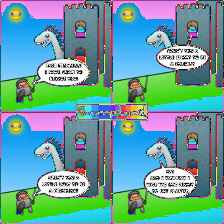

In [152]:
transforms.ToPILImage()(test_img)

In [121]:
predict(test_img)

".... I don't know what I'm doing here. I'm just doing my best. I don<pad> my best work. I just don't have time to do it. I can't help it. It's not my fault"